In [1]:
import pandas as pd, os, os.path as op, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set()



####### SET DPI HERE #######
DPI = 600 ##################
############################

u = lambda x: list(set(x))

#make necessary folders
if not op.exists('plots'):
    os.mkdir('plots')

In [2]:
q = pd.read_excel(op.join('data',"quest.xlsx"))
c = pd.read_excel(op.join('data',"cogn.xlsx"))

q = q.rename({'Participant Private ID':'id','Grupa':'group','Czy uzywa klawiatury i myszy zewnętrznej do gry lub pracy?':'keymouseuse',
         'Wiek':'age','Płec':'sex','Stan cywilny':'marital','Najwyższy ukonczony stopień edukacji':'edu',
          'Liczba ukończonych lat edukacji':'eduyears','Wielkość miasta zamieszkania':'size','Częstotliwość gry lub pracy':'pwfreq',
         'Ile pełnych lat gra lub pracuje':'pwyears','Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach':'pwhrsdaily3mo',
         'Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach':'pwhrsweekly3mo',
          'Czy kiedykolwiek czerpał korzyści materialne z grania w gry komputerowe?':'gainsever',
          'Czy obecnie utrzymuje się z grania w gry komputerowe?':'upkeepgamesnow',
         'Czy planuje kiedyś utrzymywać się z grania w gry komputerowe?':'upkeepgamesfuture'}, axis = 1)

c = c.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout'},axis=1)
c.columns = [col.lower() for col in c.columns]

q["group"] = q["group"].map({'Regularnie gram w League of Legends':"LoL",
                'Regularnie gram w Counter Strike: Global Offensive':"CS:GO",
                'Regularnie pracuję przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca",
                'Regularnie pracuję lub uczę się przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca"})

#drop columns with no variability
q = q.drop([col for col in q.columns if q[col].nunique() == 1],axis=1)


q['marital'] = q['marital'].map({'Kawaler/ panna':"Kawaler",'Żonaty/ zamężna':'Żonaty'})

#add group info to cognitive df
c["group"] = c['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})

#change nans into zeros, drop trials with more attempts than possible
c['attempt'] = c['attempt'].replace({np.nan:0})
c = c[c['attempt'] <= 5]

c['trialtype'] = c['task'].apply(lambda x: x.split(":")[-1])
c['task'] = c['task'].apply(lambda x: x.split(":")[0])
c['task'] = c['task'].map({'Go/No-Go':'gonogo','Cued Task Switching':'cts','Posner Cueing Task':'posner','Visual Search Click on Location':'vsc'})

In [3]:
cDict = {}

for task in u([t.split(":")[0] for t in c['task'].unique()]):
    cDict[task] = c[c.task.str.contains(task)]
    
    if task == 'gonogo':
        cDict[task]['trialtype'] = cDict[task]['trialtype'].apply(lambda x: x.split()[0])
    else:
        cDict[task] = cDict[task].drop(['trialtype'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [4]:
d = cDict['cts']
d = d[d['id'] != 2287534]
d = d[(d['rt'] >= 100) & (d['rt'] <= 5000)]
d = d.drop(['timeout','incorrect'], axis = 1)
d['condition'] = d['condition'].map({"KSZTAŁT":"Kształt","KOLOR":"Kolor"})

In [5]:
desc = d.groupby(['id','group']).agg(
    rt = pd.NamedAgg(column='rt', aggfunc=np.mean),
    n = pd.NamedAgg(column='rt', aggfunc=np.size)
).reset_index()

desc2 = d.groupby(['id','group','correct']).agg(
    rt = pd.NamedAgg(column='rt', aggfunc=np.mean),
    n = pd.NamedAgg(column='rt', aggfunc=np.size)
).reset_index()

In [6]:
pg.normality(data=desc, dv="rt",group='group').round(3)

,W,pval,normal
LoL,0.809,0.001,False
Praca,0.811,0.002,False
CS:GO,0.768,0.000,False


### Grupa a ogólny RT w zadaniu

In [39]:
pg.homoscedasticity(desc, group='group', dv='rt')

,W,pval,equal_var
levene,0.174855,0.840036,True


In [40]:
aov = pg.anova(dv='rt', between='group', data=desc,
               detailed=True).round(3)

In [41]:
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,136263.547,2,68131.773,0.926,0.402,0.032
1,Within,4118671.979,56,73547.714,NaN,NaN,NaN


Nie ma różnic między grupami w ogólnym RT w zadaniu CTS

### Grupa i poprawność a RT w zadaniu

In [8]:
desc2.head()

,id,group,correct,rt,n
0,2259446,LoL,0,696.300833,18.0
1,2259446,LoL,1,664.597616,302.0
2,2260116,LoL,0,449.584122,74.0
3,2260116,LoL,1,415.304224,245.0
4,2260229,LoL,0,814.332647,17.0


In [12]:
desc2['groupXcorrect'] = desc2.apply(lambda x: f"{x['group']} - incorrect trials" if x['correct'] == 0 else
            f"{x['group']} - correct trials",axis=1)

In [14]:
pg.normality(data=desc2, dv="rt",group='groupXcorrect').round(3)

,W,pval,normal
LoL - incorrect trials,0.862,0.009,False
LoL - correct trials,0.805,0.001,False
Praca - incorrect trials,0.574,0.000,False
Praca - correct trials,0.814,0.002,False
CS:GO - incorrect trials,0.780,0.000,False
CS:GO - correct trials,0.769,0.000,False


In [42]:
pg.mixed_anova(data=desc2,dv = 'rt',within='correct',between='group',subject='id').round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,631809.960,2,56,315904.980,1.271,0.288,0.043,NaN
1,correct,166907.985,1,56,166907.985,3.542,0.065,0.059,1.0
2,Interaction,74157.532,2,56,37078.766,0.787,0.460,0.027,NaN


Nie ma efektu grupy - grupy nie różnią się RT
Nie ma efektu poprawaności - nie ma różnic w RT między trialami poprawnymi i niepoprawnymi
Nie ma efektu interakcji - Grup i poprawność odp nie różnicują RT

In [45]:
corr = d.groupby(['id','group']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)
).reset_index()

### Grupa a poprawność w zadaniu

In [15]:
pg.normality(data=desc2, dv="correct",group='group').round(3)

,W,pval,normal
LoL,0.637,0.0,False
Praca,0.637,0.0,False
CS:GO,0.637,0.0,False


In [47]:
pg.homoscedasticity(corr, group='group', dv='correct')

,W,pval,equal_var
levene,0.927228,0.401637,True


In [48]:
aov = pg.anova(dv='correct', between='group', data=corr,
               detailed=True).round(3)

In [50]:
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,0.014,2,0.007,3.459,0.038,0.11
1,Within,0.112,56,0.002,NaN,NaN,NaN


Występują różnice między grupami w kontekście poprawności odpowiedzi w zadaniu

In [52]:
pg.pairwise_ttests(data=corr, dv='correct', between='group', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,LoL,Praca,0.933,0.060,0.970,0.031,False,True,-2.424,28.634,two-sided,0.022,0.064,sidak,2.91,-0.749
1,group,LoL,CS:GO,0.933,0.060,0.945,0.037,False,True,-0.741,38.000,two-sided,0.464,0.846,sidak,0.384,-0.230
2,group,Praca,CS:GO,0.970,0.031,0.945,0.037,False,True,2.329,36.489,two-sided,0.026,0.075,sidak,2.468,0.728


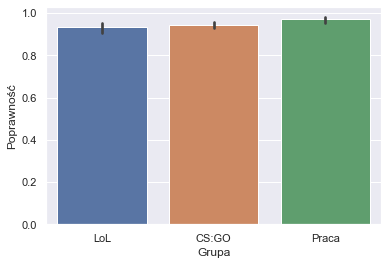

In [105]:
g = sns.barplot(data=corr,x='group',y='correct',order=['LoL',"CS:GO","Praca"])
g.set(xlabel='Grupa',ylabel='Poprawność')
plt.savefig(op.join('plots','cts_group_correctness.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

Żadne z porównań nie przeszło korekty na wielokrotne porównania Sidaka (kolumna p-corr), natomiast jeśli spojrzymy na wyniki bez korekty, to:

- LoL i CS:GO nie różnią się poprawnością wykonania zadania
- Niegrający wykonują zadanie poprawniej od reszty

In [57]:
q2 = q[['id','group','pwyears','pwhrsdaily3mo','pwhrsweekly3mo']]

#### Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a czas reakcji

In [58]:
mod1 = pd.merge(desc, q2)
mod1['group'] = mod1['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod1[f'group_{v}'] = mod1['group']*mod1[v]


### Ile pełnych lat gra lub pracuje

In [60]:
pg.linear_regression(X = mod1[['pwyears','group','group_pwyears']], y= mod1['rt'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,867.773,124.408,6.975,0.000,0.12,0.072,618.453,1117.093
1,pwyears,-45.901,28.384,-1.617,0.112,0.12,0.072,-102.785,10.982
2,group,-413.160,154.193,-2.679,0.010,0.12,0.072,-722.170,-104.150
3,group_pwyears,74.470,32.222,2.311,0.025,0.12,0.072,9.895,139.045


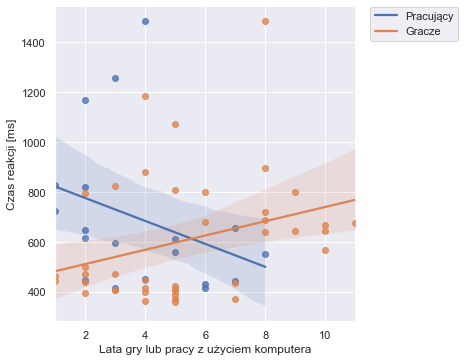

In [106]:
g = sns.lmplot(x='pwyears',y='rt',hue='group',data=mod1,legend=False)
#new_title = 'Grupa'

plt.legend(labels=["Pracujący","Gracze"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.set(xlabel="Lata gry lub pracy z użyciem komputera",ylabel = "Czas reakcji [ms]")

plt.savefig(op.join('plots','cts_pwyears_group_rt.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

Nie ma efektu lat - nie przekłada się do na zmianę czasu reakcji
Jest efekt grupy - grający wykonują zadanie szybciej od niegrających
Jest efekt interakcji, czyli mamy moderację (row 3, ale też trzeba spojrzeć na row 1)
- W rzędzie nr 1 mamy informację jak wygląda powiązanie pwyears z RT - wynik jest nieistotny, czyli de facto w grupie kontrolnej nie ma powiązania zmiennych ze sobą
- W rzędzie nr 3 mamy informację o tym samym powiązaniu ale w grupie graczy - tutaj wynik jest istotny, a współczynnik (coef) jest na +, co oznacza, że im ktoś dłużej ktoś korzysta z komputera, tym dłużej rozwiązuje zadanie.


### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [67]:
pg.linear_regression(X = mod1[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod1['rt'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,876.630,210.989,4.155,0.000,0.065,0.014,453.800,1299.461
1,pwhrsdaily3mo,-29.572,32.215,-0.918,0.363,0.065,0.014,-94.132,34.988
2,group,-353.581,224.510,-1.575,0.121,0.065,0.014,-803.509,96.346
3,group_pwhrsdaily3mo,44.319,34.125,1.299,0.199,0.065,0.014,-24.068,112.707


Średnia liczba godzin gry/pracy dziennie oraz grupa nie przekładają się na RT w zadaniu

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [69]:
pg.linear_regression(X = mod1[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod1['rt'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,776.644,196.691,3.949,0.000,0.065,0.014,382.466,1170.823
1,pwhrsweekly3mo,-2.646,5.798,-0.456,0.650,0.065,0.014,-14.266,8.974
2,group,-271.605,211.896,-1.282,0.205,0.065,0.014,-696.254,153.044
3,group_pwhrsweekly3mo,5.598,6.110,0.916,0.364,0.065,0.014,-6.646,17.843


Średnia liczba godzin gry/pracy tygodniowo oraz grupa nie przekładają się na RT w zadaniu

In [70]:
mod2 = d.groupby(['id','group']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)).reset_index()

mod2 = pd.merge(mod2, q2)
mod2['group'] = mod2['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod2[f'group_{v}'] = mod2['group']*mod2[v]

#### Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a poprawność odpowiedzi

### Ile pełnych lat gra lub pracuje

In [71]:
pg.linear_regression(X = mod2[['pwyears','group','group_pwyears']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.975,0.022,45.089,0.000,0.102,0.053,0.932,1.018
1,pwyears,-0.001,0.005,-0.252,0.802,0.102,0.053,-0.011,0.009
2,group,-0.031,0.027,-1.163,0.250,0.102,0.053,-0.085,0.023
3,group_pwyears,0.000,0.006,0.063,0.950,0.102,0.053,-0.011,0.012


Nie ma żadnego efektu, ani lata, ani bycie graczem/niegraczem, ani też interakcja nie prekładają się na poprawność

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [72]:
pg.linear_regression(X = mod2[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.981,0.034,28.536,0.000,0.162,0.116,0.912,1.050
1,pwhrsdaily3mo,-0.002,0.005,-0.333,0.740,0.162,0.116,-0.012,0.009
2,group,-0.021,0.037,-0.582,0.563,0.162,0.116,-0.095,0.052
3,group_pwhrsdaily3mo,-0.002,0.006,-0.344,0.732,0.162,0.116,-0.013,0.009


Nie ma żadnego efektu, ani czas gry/pracy dziennie w ostatnich 3 mies, ani bycie graczem/niegraczem, ani też interakcja nie prekładają się na poprawność

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [73]:
pg.linear_regression(X = mod2[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.991,0.032,30.968,0.000,0.164,0.118,0.927,1.055
1,pwhrsweekly3mo,-0.001,0.001,-0.697,0.489,0.164,0.118,-0.003,0.001
2,group,-0.031,0.034,-0.909,0.368,0.164,0.118,-0.100,0.038
3,group_pwhrsweekly3mo,0.000,0.001,0.049,0.961,0.164,0.118,-0.002,0.002


Nie ma żadnego efektu, ani czas gry/pracy tygodniowo w ostatnich 3 mies, ani bycie graczem/niegraczem, ani też interakcja nie prekładają się na poprawność